In [ ]:

# # Diff-SCM
# 
# This tutorial illustrates how to load the 2D BRATS dataset.
# 
# 
# ## Setup environment

In [16]:


get_ipython().system('python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"')
get_ipython().system('python -c "import matplotlib" || pip install -q matplotlib')
get_ipython().run_line_magic('matplotlib', 'inline')
print('done')


# ## Setup imports

done


In [17]:


# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer

# TODO: Add right import reference after deployed
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()


# ## Setup data directory

MONAI version: 1.1.dev2248
Numpy version: 1.23.2
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 3400bd91422ccba9ccc3aa2ffe7fecd4eb5596bf
MONAI __file__: /home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://d

In [23]:


directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
root_dir= '/tmp/tmp6o69ziv1'


# ## Set deterministic training for reproducibility

/tmp/tmpf7ygl4zq


In [24]:


set_determinism(42)


# ## Setup MedNIST Dataset and training and validation dataloaders
# In this tutorial, we will train our models on the MedNIST dataset available on MONAI
# (https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset).
# Here, we will use the "Hand" and "HeadCT", where our conditioning variable `class` will specify the modality.

In [25]:


batch_size = 2
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image","label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image","label"]),
        transforms.Orientationd(keys=["image","label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image","label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0 ).float().squeeze()),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
nb_3D_images_to_mix = 2
train_loader_3D = DataLoader(train_ds, batch_size=nb_3D_images_to_mix, shuffle=True, num_workers=4)
print(f'Image shape {train_ds[0]["image"].shape}')

2023-01-20 09:47:29,125 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-01-20 09:47:29,126 - INFO - File exists: /tmp/tmp6o69ziv1/Task01_BrainTumour.tar, skipped downloading.
2023-01-20 09:47:29,127 - INFO - Non-empty folder exists in /tmp/tmp6o69ziv1/Task01_BrainTumour, skipped extracting.
Image shape torch.Size([1, 64, 64, 64])


In [26]:


from typing import Dict
def get_batched_2d_axial_slices(data : Dict):
    images_3D = data['image']
    batched_2d_slices = torch.cat(images_3D.split(1, dim = -1), 0).squeeze(-1) # images_3D.view(images_3D.shape[0]*images_3D.shape[-1],*images_3D.shape[1:-1])
    slice_label = data['slice_label']
    #slice_label = (mask_label.reshape(mask_label.shape[0], -1, mask_label.shape[-1]).sum(1) > 0 ).float()
    slice_label = torch.cat(slice_label.split(1, dim = -1),0).squeeze()
    return batched_2d_slices, slice_label


# ### Visualisation of the training images

In [37]:


check_data = first(train_loader_3D)
print('check_data', check_data["image"].shape, check_data["slice_label"].shape)

check_data torch.Size([2, 1, 64, 64, 64]) torch.Size([2, 64])


idx [tensor(125), tensor(70), tensor(71), tensor(10), tensor(112), tensor(72), tensor(100), tensor(108), tensor(48), tensor(90), tensor(5), tensor(83), tensor(53), tensor(38), tensor(121), tensor(115), tensor(116), tensor(75), tensor(34), tensor(2), tensor(118), tensor(46), tensor(57), tensor(64), tensor(107), tensor(126), tensor(109), tensor(98), tensor(15), tensor(13), tensor(113), tensor(93), tensor(106), tensor(73), tensor(4), tensor(102), tensor(21), tensor(96), tensor(30), tensor(18), tensor(91), tensor(16), tensor(77), tensor(49), tensor(50), tensor(123), tensor(28), tensor(42), tensor(23), tensor(6), tensor(12), tensor(65), tensor(31), tensor(41), tensor(3), tensor(101), tensor(67), tensor(54), tensor(62), tensor(120), tensor(94), tensor(80), tensor(35), tensor(9), tensor(82), tensor(84), tensor(14), tensor(32), tensor(127), tensor(59), tensor(25), tensor(63), tensor(87), tensor(92), tensor(40), tensor(97), tensor(51), tensor(7), tensor(105), tensor(19), tensor(88), tensor(36),

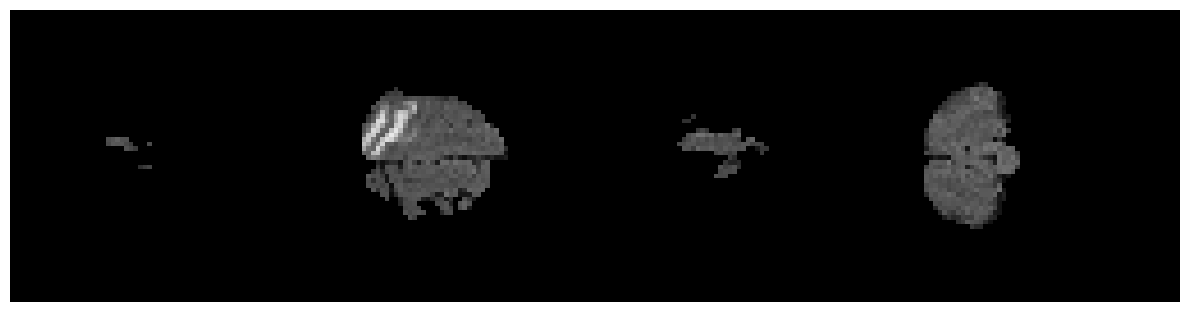

In [38]:


batched_2d_slices, slice_label = get_batched_2d_axial_slices(check_data)
idx = list(torch.randperm(batched_2d_slices.shape[0]))
print('idx', idx, len(idx))
slices = [0,30,45,63]
print(f"Batch shape: {batched_2d_slices.shape}")
print(f"Slices class: {slice_label[idx][slices].view(-1)}")
image_visualisation = torch.cat(batched_2d_slices[idx][slices].squeeze().split(1), dim=2).squeeze()
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [39]:


slice_label.shape


# ## Check Distribution of Healthy / Unhealthy

torch.Size([128])

In [40]:

subset_2D = zip(batched_2d_slices.split(batch_size),slice_label.split(batch_size))#
a,b = next(subset_2D)  #what is a, what is b?
a.shape, b.shape

(torch.Size([2, 1, 64, 64]), torch.Size([2]))

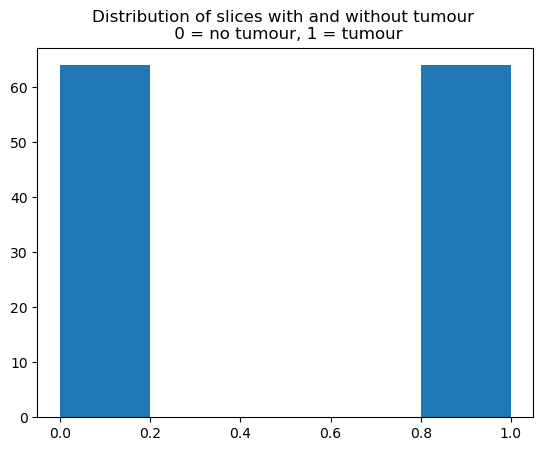

In [41]:


plt.hist(slice_label.view(-1).numpy(),bins = 5);
plt.title("Distribution of slices with and without tumour \n 0 = no tumour, 1 = tumour");